In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision as vision
import cv2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import pandas as pd
from tqdm import tqdm

from random import shuffle, randint
from copy import deepcopy
from pathlib import Path

sns.set()

# Датасет и нейросеть
Для данной задачи классификации используем простой вариант сверточной нейросети (класс SimpleCNN), состоящей из нескольких блоков. Размер ядра = 3. Выход - 1 нейрон (Sigmoid).
Метки классов: 
   0 - open, 
   1 - sunglasses.

In [3]:
class SimpleCNN(nn.Module):

    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, bias=False),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, bias=False),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, bias=False),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(128, 1)

    def forward(self, x):
        emb = self.net(x)
        emb = emb.view(emb.size(0), -1)
        return torch.sigmoid(self.out(emb)).squeeze(1)


class MyImageDataset(Dataset):

    def __init__(self, images_path, tags_path=None):
        self.images_path = images_path
        self.tags_path = tags_path
        self.image_names = []
        
        self.X = []
        self.y = []
        self.class_to_label = {"open": 0, "sunglasses": 1}
        if tags_path:
            df = pd.read_csv(tags_path)
            image_id_to_class = {str(row["id"]): self.class_to_label[row["tag"]] for _, row in df.iterrows()}
        # print(image_id_to_class)
        for image_path in Path(images_path).glob("*jpg"):
            with torch.no_grad():
                image = cv2.imread(str(image_path))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                self.X.append(image)
                self.image_names.append(image_path)
            if tags_path:
                image_id = str(image_path.name)[:-4]
                self.y.append(image_id_to_class[image_id])

    def __getitem__(self, index):
        x = torch.FloatTensor(self.X[index] / 255).unsqueeze(0)
        if self.y:
            return x, self.y[index]
        return x

    def __len__(self):
        return len(self.X)

    def extend_with_augmentations(self, iterations):
        original_size = len(self)
        transform = A.Compose([
            # A.RandomRotate90(),
            A.Flip(),
            # A.Transpose(),
            A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.0, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
        ])
        for iteration in range(iterations):
            for idx in range(original_size):
                image = self.X[idx]
                y = self.y[idx]
                new_image = transform(image=image)["image"]
                self.X.append(new_image)
                self.y.append(y)
                
        

def shuffle_and_cross_validate(dataset, validation_fraction):
    images_labels_names = list(zip(dataset.X, dataset.y, dataset.image_names))
    shuffle(images_labels_names)
    dataset.X, dataset.y, dataset.image_names = zip(*images_labels_names)
    images_for_validation = int(validation_fraction * len(dataset))
    # print(images_for_validation)
    for split in range(len(dataset) // images_for_validation):
        validation_start = split * images_for_validation
        validation_end = (split + 1) * images_for_validation
        # print(validation_start, validation_end)
        train_dataset = deepcopy(dataset)
        validation_dataset = deepcopy(dataset)

        train_dataset.X = train_dataset.X[:validation_start] + train_dataset.X[validation_end:]
        train_dataset.y = train_dataset.y[:validation_start] + train_dataset.y[validation_end:]
        train_dataset.image_names = train_dataset.image_names[:validation_start] + train_dataset.image_names[validation_end:]
        
        validation_dataset.X = validation_dataset.X[validation_start:validation_end]
        validation_dataset.y = validation_dataset.y[validation_start:validation_end]
        validation_dataset.image_names = validation_dataset.image_names[validation_start:validation_end]
        dataset.X = list(dataset.X)
        dataset.y = list(dataset.y)

        train_dataset.X = list(train_dataset.X)
        train_dataset.y = list(train_dataset.y)

        validation_dataset.X = list(validation_dataset.X)
        validation_dataset.y = list(validation_dataset.y)
        
        yield train_dataset, validation_dataset


# Чтение данных
Картинки храним в памяти, так как суммарно они занимают всего ~90 Мб. Если бы датасет был больше, пришлось бы загружать картинки с диска в функции __getitem\_\_ класса MyImageDataset.

In [4]:
test_dataset = MyImageDataset("test/")
train_val_dataset = MyImageDataset("train", "train_tags.csv")
for train_dataset, val_dataset in shuffle_and_cross_validate(train_val_dataset, 0.2):
    break

BATCH_SIZE = 16

# train_dataset.extend_with_augmentations(3)
# val_dataset.extend_with_augmentations(3)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(val_dataset))
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Функции для обучения нейросети и получения предсказаний
В функции обучения train можно задать параметр для l2 регуляризации (weight_decay в оптимизаторе Adam) и dropout, который будет применен перед финальным линейным слоем.

Аугментации можно сделать после чтения датасета с помощью метода `MyImageDataset.extend_with_augmentations(n)`, тем самым увеличив исходный датасет в n раз.

Функция обучения train сохраняет веса моделей и отслеживает по эпохам значения функции потерь и метрики Accuracy (точность). 

В обучение встроен механизм early stopping: обучение останавливается, если прошло 10 (константа STALE_EPOCHS) эпох обучения без улучшения Accuracy на валидационной выборке. 

Функция train возвращает модель, в которую загружены лучшие веса, соответствующие лучшей Accuracy на валидации, а также списки с средними значениями функции потерь и точности по обучающим и валидационным выборкам по всем пройденным эпохам.

In [5]:
def train(train_loader, val_loader, l2_reg=0, dropout=0.0):
    cnn = SimpleCNN(dropout=dropout).train()
    loss_func = nn.BCELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=l2_reg)
    train_losses = []
    train_epoch_losses = []
    train_epoch_accuracy = []
    eval_epoch_losses = []
    eval_epoch_accuracy = []
    best_accuracy = 0
    best_accuracy_epoch = 0
    epochs_without_improvement = 0
    STALE_EPOCHS = 10
    EPOCHS = 50
    best_ckpt_path = ""
    for epoch in range(EPOCHS):
        losses = []
        # Train
        total = 0
        correct = 0
        cnn = cnn.train()
        for i, batch in enumerate(train_loader):
            x, y = batch
            y_pred = cnn(x)
            loss = loss_func(y_pred, y.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            # accuracy
            with torch.no_grad():
                total += y.size(0)
                correct += ((y_pred > 0.5).long() == y).sum().item()
        train_losses += losses
        train_epoch_losses.append(sum(losses) / len(losses))
        train_epoch_accuracy.append(correct / total)
        # print("Train", correct, total)
        # Validation
        losses = []
        total = 0
        correct = 0
        cnn = cnn.eval()
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                x, y = batch
                y_pred = cnn(x)
                loss = loss_func(y_pred, y.float())    
                losses.append(loss.item())
                total += y.size(0)
                correct += ((y_pred > 0.5).long() == y).sum().item()
        eval_epoch_losses.append(sum(losses) / len(losses))
        eval_acc = correct / total
        eval_epoch_accuracy.append(eval_acc)
        torch.save(cnn.state_dict(), f"cnn_epoch_{epoch}_acc_{eval_acc}.pt")
        if eval_acc > best_accuracy:
            best_accuracy = eval_acc
            epochs_without_improvement = 0
            best_accuracy_epoch = epoch
            best_ckpt_path = f"cnn_epoch_{epoch}_acc_{eval_acc}.pt"
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= STALE_EPOCHS:
                break

    print("Trained for", epoch + 1, "epochs, best epoch is", best_accuracy_epoch, "accuracy", best_accuracy)
    EPOCHS = epoch + 1

    cnn.load_state_dict(torch.load(best_ckpt_path))

    return cnn, train_epoch_losses, eval_epoch_losses, train_epoch_accuracy, eval_epoch_accuracy


def predict_on_dataset(model, dataset, batch_size=BATCH_SIZE):
    model = model.eval()
    preds_all = []
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for batch in tqdm(dataloader):
        with torch.no_grad():
            preds = model(batch).tolist()
        preds_all += preds
    return preds_all


def plot_loss_and_accuracy(train_epoch_losses, eval_epoch_losses, train_epoch_accuracy, eval_epoch_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title("Loss")
    axes[0].plot(train_epoch_losses, label="Train")
    axes[0].plot(eval_epoch_losses, label="Eval")
    axes[0].legend()
    axes[1].set_title("Accuracy")
    axes[1].plot(train_epoch_accuracy, label="Train")
    axes[1].plot(eval_epoch_accuracy, label="Eval")
    axes[1].legend()

# Тестовое обучение без аугментаций и регуляризации

Trained for 17 epochs, best epoch is 6 accuracy 0.9866666666666667


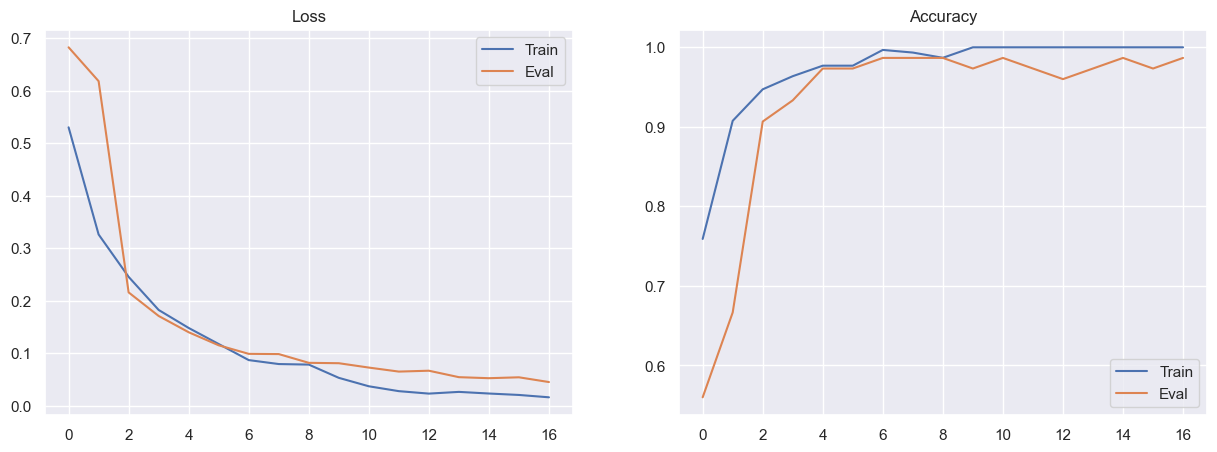

In [6]:
cnn, train_epoch_losses, eval_epoch_losses, train_epoch_accuracy, eval_epoch_accuracy = train(train_loader, val_loader)
plot_loss_and_accuracy(train_epoch_losses, eval_epoch_losses, train_epoch_accuracy, eval_epoch_accuracy)

# Кросс-валидация базового обучения
Функция shuffle_and_cross_validate генерирует пары обучающего и валидационного датасета, разбитые из исходного в заданной пропорции (для примера выбрано популярное значение 80/20). 

С помощью написанных функций можно посчитать кросс-валидацию на нескольких разбиениях и усреднить значения Accuracy на валидационной выборке, чтобы точнее оценить качество работы модели.

Так как выборка однородная, а картинки простые (небольшого размера), то даже модель без аугментаций и регуляризации показывает на валидации хорошее качество (0.95+ по метрике Accuracy).

Обучим финальную версию модели, которая будет использовать регуляризацию и дропаут на аугментированном датасете, и проведем кросс-валидацию.

In [13]:
eval_accuracies = []
for train_dataset, val_dataset in shuffle_and_cross_validate(train_val_dataset, 0.2):
    train_dataset.extend_with_augmentations(3)
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(train_dataset))
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(val_dataset))
    cnn, train_epoch_losses, eval_epoch_losses, train_epoch_accuracy, eval_epoch_accuracy = train(train_loader, val_loader, 0.01, 0.2)
    eval_accuracy = max(eval_epoch_accuracy)
    eval_accuracies.append(eval_accuracy)

print("Accuracy CV:", eval_accuracies)
print("AVG Accuracy CV:", sum(eval_accuracies) / len(eval_accuracies))

Trained for 20 epochs, best epoch is 9 accuracy 0.96
Trained for 16 epochs, best epoch is 5 accuracy 1.0
Trained for 24 epochs, best epoch is 13 accuracy 0.9733333333333334
Trained for 14 epochs, best epoch is 3 accuracy 0.9866666666666667
Trained for 26 epochs, best epoch is 15 accuracy 0.9866666666666667
Accuracy CV: [0.96, 1.0, 0.9733333333333334, 0.9866666666666667, 0.9866666666666667]
AVG Accuracy CV: 0.9813333333333333


# Получение предсказаний и их визуализация
Получим предсказания модели на тестовом датасете и визуализируем несколько картинок для ручной проверки качества. Примеры наглядно показывают высокую точность предсказания нейросети.

In [14]:
predictions = predict_on_dataset(cnn, test_dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1384/1384 [00:01<00:00, 967.22it/s]


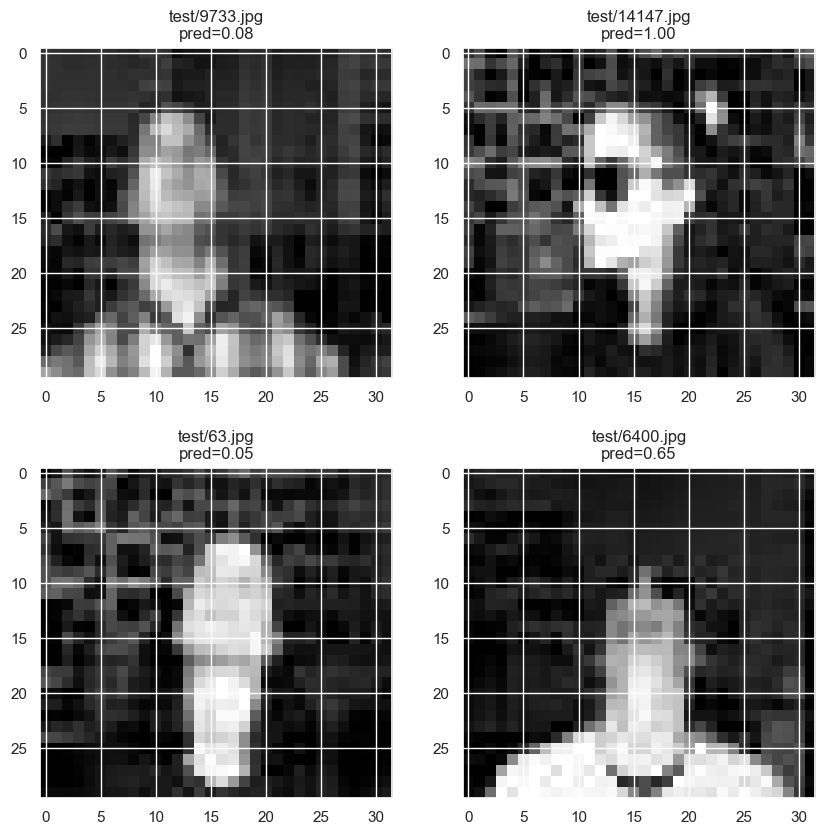

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
random_idx = [randint(0, len(test_dataset)) for _ in range(4)]
for k in range(4):
    i = k // 2
    j = k % 2
    ax = axes[i][j]
    ax.imshow(test_dataset[random_idx[k]][0], cmap="gray")
    ax.set_title(f"{test_dataset.image_names[k]}\npred={'%0.2f' % predictions[random_idx[k]]}")

# Генерация посылки
Класс 1, если предсказание модели больше порога 0.5, иначе - класс 0.

In [16]:
ids = []
preds = []
for image_name, pred in zip(test_dataset.image_names, predictions):
    image_id = int(image_name.stem)
    ids.append(image_id)
    preds.append(1 if pred > 0.5 else 0)

ids_and_preds = list(zip(ids, preds))
ids_and_preds = sorted(ids_and_preds, key=lambda x: x[0])
ids, preds = zip(*ids_and_preds)

In [17]:
df = pd.DataFrame({"id": ids, "result": preds})
df.to_csv("/Users/sofia/Desktop/Софья_Цициковская.csv", index=False)